In [39]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("omw-1.4")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")
from Preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fmele\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fmele\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fmele\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fmele\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fmele\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
# load data
songs_data = pd.read_csv("data/top50_2018_2022.csv")
# primary artists -> separate by comma
songs_data["Primary Artists"] = songs_data["Primary Artists"].str.replace(" & ",",")
songs_data["Primary Artists"] = songs_data["Primary Artists"].str.replace(", ", ",")
songs_data["Primary Artists"] = songs_data["Primary Artists"].str.split(",")
bad_words_data = pd.read_csv("data/bad-words.csv")

# remove some words from the bad_words_data
not_bad_words = ["gun","blow","black","chinese"]
bad_words_data = bad_words_data.drop(index=bad_words_data[bad_words_data["jigaboo"].isin(not_bad_words)].index)

In [41]:
def preprocess_swear_word(word):
    if "motherfuck" in word or word.startswith("mothaf"):
        return "motherfuck"
    if word.startswith("fuck"):
        return "fuck"
    return word

In [42]:
def preprocess_lyrics(lyrics):
    # Remove punctuation
    lyrics = re.sub("[^a-zA-Z0-9\s]", "", lyrics)
    # Convert to lowercase
    lyrics = lyrics.lower()
    # Tokenize into individual words
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(i,j[0].lower()) if j[0].lower() in ["a","n","v"] else lemmatizer.lemmatize(i) for i,j in nltk.pos_tag(nltk.word_tokenize(lyrics))]
    words = [preprocess_swear_word(w) for w in lemmatized_words if w not in stop_words]
    return words

In [43]:
songs_data["Lyrics"] = songs_data["Lyrics"].apply(lambda x: preprocess_lyrics(x))
songs_data

,position,title,artist,year,Lyrics,Primary Artists
0,1,God's Plan,Drake,2018,"[wishin, wishin, wishin, wishin, wishin, yeah,...",[Drake]
1,2,I Like It,"Cardi B, Bad Bunny & J Balvin",2018,"[yeah, baby, like, like, get, ta, believe, tel...","[Cardi B, Bad Bunny, J Balvin]"
2,3,In My Feelings,Drake,2018,"[trap, trapmoneybenny, shit, get, feeling, get...",[Drake]
3,4,Psycho,Post Malone Featuring Ty Dolla $ign,2018,"[damn, ap, goin, psycho, lil, mama, bad, like,...",[Post Malone]
4,5,Nice For What,Drake,2018,"[wan, na, know, motherfuck, representin, tonig...",[Drake]
...,...,...,...,...,...,...
245,46,Already Dead,Juice WRLD,2022,"[see, pain, laugh, yeah, yeah, demon, comin, b...",[Juice WRLD]
246,47,Family Ties,Baby Keem & Kendrick Lamar,2022,"[jump, hah, hah, summon, bitch, jump, hah, hah...","[Baby Keem, Kendrick Lamar]"
247,48,Alone,Rod Wave,2022,"[b, square, beat, oh, ohwoah, ohwoah, tell, se...",[Rod Wave]
248,49,Plan B,Megan Thee Stallion,2022,"[fuck, think, talkin, nigga, fuck, nah, nigga,...",[Megan Thee Stallion]


In [44]:
def word_count_dict_to_df(word_dict):
    df = pd.DataFrame.from_dict(word_dict, orient="index", columns=["count"])#.reset_index()
    df.index.name = "word"
    return df

In [45]:
# I want a df with all the word counts and whether they are swear words
all_words_swear = word_count_dict_to_df(create_word_count_dict(songs_data))
all_words_swear["swear word"] = all_words_swear.index.isin(bad_words_data["jigaboo"])
# sort
all_words_swear = all_words_swear.sort_values(["swear word", "count"], ascending=[False, False])

In [46]:
all_words_swear

,count,swear word
word,,
nigga,1087,True
bitch,1084,True
fuck,886,True
shit,773,True
pussy,183,True
...,...,...
akimbos,1,False
mitt,1,False
kimbo,1,False


In [47]:
# a dictionary of word use per year and artist
words_dict = create_word_count_dict_grouped(songs_data, True, True)
# create df
words_df_dict = {}
for key in words_dict.keys():
    words_df_dict[key] = word_count_dict_to_df(words_dict[key])
    words_df_dict[key]["swear word"] = words_df_dict[key].index.isin(bad_words_data["jigaboo"])
    # sort
    words_df_dict[key] = words_df_dict[key].sort_values(["swear word", "count"], ascending=[False, False])

# also a df just for the year
words_year_dict = create_word_count_dict_grouped(songs_data, False, True)
words_df_year_dict = {}
for key in words_year_dict.keys():
    words_df_year_dict[key] = word_count_dict_to_df(words_year_dict[key])
    words_df_year_dict[key]["swear word"] = words_df_year_dict[key].index.isin(bad_words_data["jigaboo"])
    # sort
    words_df_year_dict[key] = words_df_year_dict[key].sort_values(["swear word", "count"], ascending=[False, False])

In [48]:
words_df_dict[("21 Savage", 2018)]

,count,swear word
word,,
god,35,True
bitch,12,True
shit,5,True
nigga,4,True
kill,3,True
...,...,...
busy,1,False
matte,1,False
black,1,False


In [49]:
# Count total swear word count per year per artist
swear_by_year_artist = pd.DataFrame()

for (artist, year), df in words_df_dict.items():
    total_word_count = df["count"].sum()
    swear_count = df[df["swear word"]]["count"].sum()
    swear_proportion = swear_count / total_word_count

    temp_df = pd.DataFrame({"year": year, "artist": artist, "swear_count": swear_count, "total_word_count": total_word_count, "swear_proportion": swear_proportion}, index=[0])
    swear_by_year_artist = pd.concat([swear_by_year_artist, temp_df], ignore_index=True)

top_artists = swear_by_year_artist.groupby("artist")["swear_proportion"].sum().sort_values(ascending=False).head(10).index.tolist()

swear_by_year_artist

,year,artist,swear_count,total_word_count,swear_proportion
0,2018,21 Savage,71,442,0.160633
1,2019,21 Savage,34,518,0.065637
2,2021,21 Savage,67,727,0.092160
3,2020,24kGoldn,3,239,0.012552
4,2020,42 Dugg,41,493,0.083164
...,...,...,...,...,...
201,2021,Young Thug,14,290,0.048276
202,2018,YoungBoy Never Broke Again,10,242,0.041322
203,2020,YoungBoy Never Broke Again,28,330,0.084848
204,2022,Yung Gravy,8,280,0.028571


# Popular Vulgar Words
## Word Cloud of most frequent vulgar words
The word cloud displays the most prominent vulgar words in rap songs which a bigger font size.

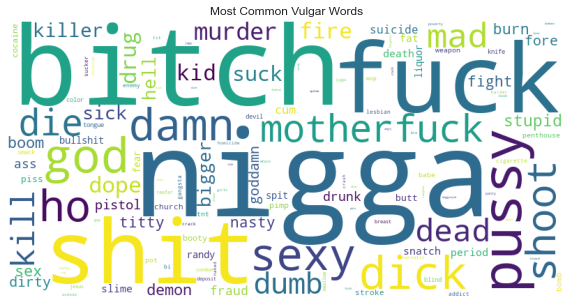

In [50]:
swear_word_freq = all_words_swear[all_words_swear["swear word"]]["count"].to_dict()

wordcloud = WordCloud(width=800, height=400, background_color="white")
wordcloud.generate_from_frequencies(swear_word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Most Common Vulgar Words")
plt.show()

## Which year saw the highest usage of vulgar words (proportional to the total number of words)?
As can be seen on the bar plot, the trend of using vulgar words barely changes over the years 2018 to 2022. In this range, 2019 saw the highest proportion of swear words (8.4%).

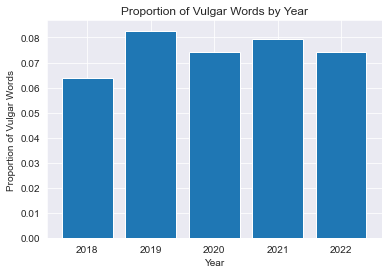

In [51]:
swear_proportions_by_year = {}

for year, df in words_df_year_dict.items():
    total_word_count = df["count"].sum()
    swear_count = df[df["swear word"]]["count"].sum()
    swear_proportion = swear_count / total_word_count
    swear_proportions_by_year[year] = swear_proportion

years = [year[0] for year in words_df_year_dict.keys()]
proportions = list(swear_proportions_by_year.values())

plt.bar(years, proportions)
plt.xlabel("Year")
plt.ylabel("Proportion of Vulgar Words")
plt.title("Proportion of Vulgar Words by Year")
plt.show()

## Development of popularity of vulgar words over years
Generally, the popularity of each of the most common vulgar words does not change over the years. A notable change can be seen in the word "shit" though. After 2020, transitioning to 2021, it experienced a sharp increase in usage.

A word that appears to have an upward trend in popularity is "Pussy" - the 5th most popular word in years 2019 to 2022.

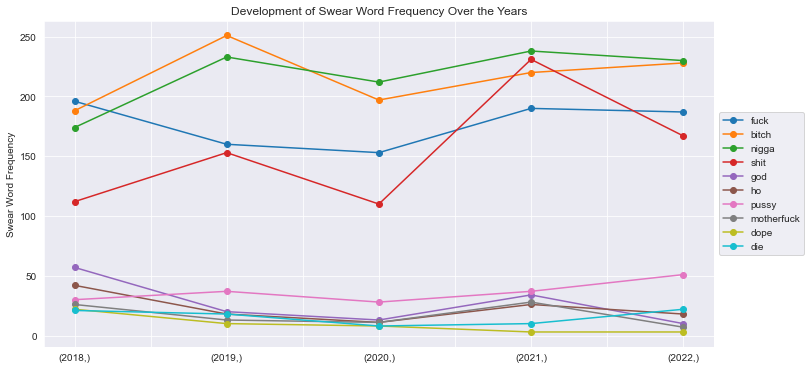

In [52]:
swear_freq_by_year = pd.DataFrame()

for year, df in words_df_year_dict.items():
    swear_words = df[df["swear word"]]
    swear_freq = swear_words["count"]
    swear_freq.index = swear_words.index
    temp_df = pd.DataFrame(swear_freq).T
    temp_df.index = [year]
    swear_freq_by_year = pd.concat([swear_freq_by_year, temp_df], ignore_index=False)

# Select the first 10 columns
swear_freq_by_year = swear_freq_by_year.iloc[:, :10]

swear_freq_by_year.plot(marker="o", linestyle="-", figsize=(12, 6))
plt.ylabel("Swear Word Frequency")
plt.title("Development of Swear Word Frequency Over the Years")
# Move the legend outside of the plot area to the right
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# Which artist is the most toxic one?
To answer that question, we look at the artists with the highest proportion of vulgar words in their song lyrics.


"Sheck Wes" had the highest proportion of vulgar words across his songs, almost 30 per cent!
However, multiple artists exist that barely use any swear words - as the bar plot illustrates.

A heatmap intends to display the development of the vulgar word usage among the artists in each year. Overall it is safe to say, that the vulgarity seems to remain consistent across the different years for each artist. Although one could argue that artists who previously used few vulgar words tend to use more, there is not enough data to draw such a conclusion.

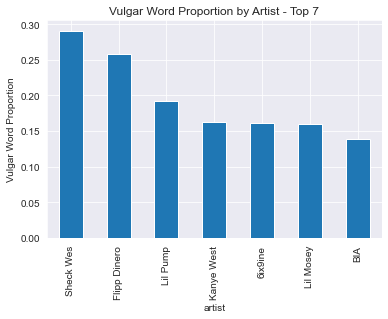

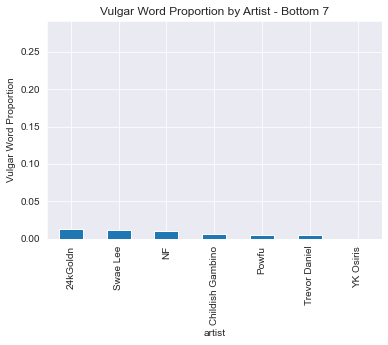

In [77]:
# proportion of swear words per artist over all years
artist_swears = swear_by_year_artist.groupby("artist")["swear_proportion"].mean().sort_values(ascending=False)
# plot top 7
artist_swears.head(7).plot(kind="bar")
plt.ylabel("Vulgar Word Proportion")
plt.title("Vulgar Word Proportion by Artist - Top 7")
plt.show()

# bottom 7
artist_swears.tail(7).plot(kind="bar")
plt.ylabel("Vulgar Word Proportion")
plt.title("Vulgar Word Proportion by Artist - Bottom 7")
plt.ylim([0,artist_swears.values[0]])
plt.show()

In [54]:
n = 15
# top n artists with the highest swear word proportions
top_artists = list(artist_swears.head(n).index)
# top n artists with the lowest swear word proportions
bottom_artists = list(artist_swears.tail(n).index)

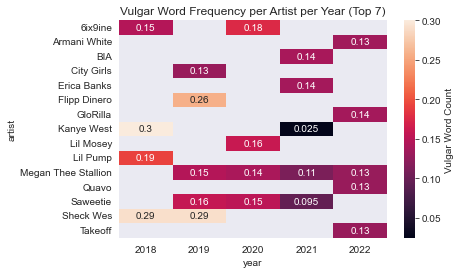

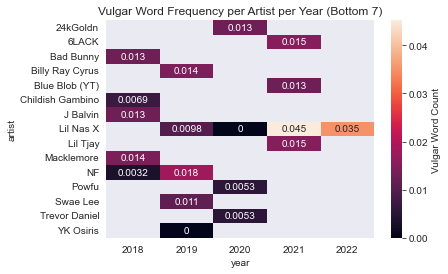

In [55]:
# heatmap of top n toxic artists
swear_by_year_artist_filtered = swear_by_year_artist[swear_by_year_artist["artist"].isin(top_artists)]
swear_by_year_artist_pivot_heatmap = swear_by_year_artist_filtered.pivot_table(index="artist", columns="year", values="swear_proportion", fill_value=None)
sns.heatmap(swear_by_year_artist_pivot_heatmap, annot=True,  cbar_kws={"label": "Vulgar Word Count"})
plt.title("Vulgar Word Frequency per Artist per Year (Top 7)")
plt.show()

# heatmap of least n toxic artists
swear_by_year_artist_filtered = swear_by_year_artist[swear_by_year_artist["artist"].isin(bottom_artists)]
swear_by_year_artist_pivot_heatmap = swear_by_year_artist_filtered.pivot_table(index="artist", columns="year", values="swear_proportion", fill_value=None)
sns.heatmap(swear_by_year_artist_pivot_heatmap, annot=True,  cbar_kws={"label": "Vulgar Word Count"})
plt.title("Vulgar Word Frequency per Artist per Year (Bottom 7)")
plt.show()

# Correlation between song ranking and swear word proportion
As the scatter plot below shows, there seems to be no clear correlation between the song ranking and the swear words.

In [56]:
# create a dictionary keyed by the song title which contains the swear word proportion
song_swear_proportion_dict = {}

for index, row in songs_data.iterrows():
    words = row["Lyrics"]
    title = row["title"]
    word_counts = dict(Counter(words))
    df = word_count_dict_to_df(word_counts)
    df["swear word"] = df.index.isin(bad_words_data["jigaboo"])
    # swear word proportion
    total_words =  df["count"].sum()
    swear_words =  df[df["swear word"]]["count"].sum()
    song_swear_proportion_dict[title] = swear_words/total_words

swear_proportion_data = []

for title, proportion in song_swear_proportion_dict.items():
    ranking = songs_data.loc[songs_data["title"] == title, "position"].values[0]
    swear_proportion_data.append({"title": title, "ranking": ranking, "swear_proportion": proportion})

swear_proportion_df = pd.DataFrame(swear_proportion_data)
swear_proportion_df = swear_proportion_df.sort_values("swear_proportion", ascending=False)
swear_proportion_df

,title,ranking,swear_proportion
41,I Love It,42,0.300000
47,Mo Bamba,48,0.290909
74,Leave Me Alone,28,0.257525
224,Plan B,49,0.224658
23,Gummo,24,0.222672
...,...,...,...
108,Death Bed,15,0.005348
105,Falling,12,0.005263
14,Let You Down,15,0.003215
76,Worth It,31,0.000000


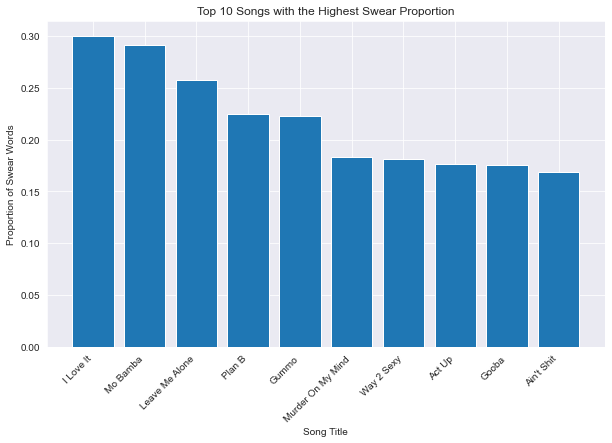

In [57]:
# Create a bar plot of the top n songs
n = 10
plt.figure(figsize=(10, 6))
plt.bar(swear_proportion_df.head(n)["title"], swear_proportion_df.head(n)["swear_proportion"])
plt.xlabel("Song Title")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Proportion of Swear Words")
plt.title("Top " + str(n) + " Songs with the Highest Swear Proportion")
plt.show()

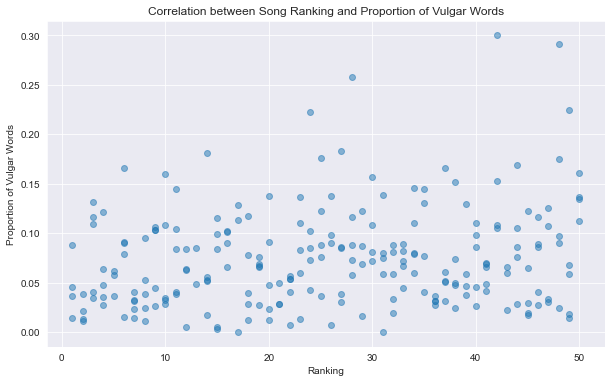

In [58]:
plt.figure(figsize=(10, 6))
plt.scatter(swear_proportion_df["ranking"], swear_proportion_df["swear_proportion"], alpha=0.5)
plt.xlabel("Ranking")
plt.ylabel("Proportion of Vulgar Words")
plt.title("Correlation between Song Ranking and Proportion of Vulgar Words")
plt.show()